In [114]:
from Utils.ConfigProvider import ConfigProvider
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
config = ConfigProvider.config()
%matplotlib inline
%load_ext autoreload
%autoreload 2

Enter config
Leave config
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let’s look at the data


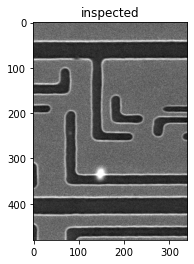

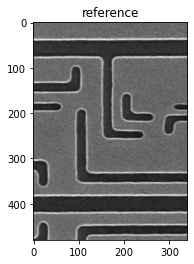

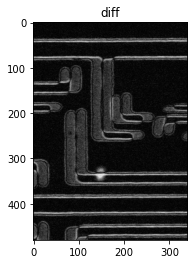

In [115]:
inspected1 = cv2.imread(config.data.non_defective_inspected_path, 0)
reference1 = cv2.imread(config.data.non_defective_reference_path, 0)
inspected2 = cv2.imread(config.data.defective_inspected_path1, 0)
reference2 = cv2.imread(config.data.defective_reference_path1, 0)
inspected3 = cv2.imread(config.data.defective_inspected_path2, 0)
reference3 = cv2.imread(config.data.defective_reference_path2, 0)

inspected = inspected2
reference = reference2

diff = np.abs(np.array(inspected, dtype=np.int) - np.array(reference, dtype=np.int))

plt.figure()
plt.title('inspected')
plt.imshow(inspected, cmap='gray')
plt.figure()
plt.title('reference')
plt.imshow(reference, cmap='gray')
plt.figure()
plt.title('diff')
plt.imshow(diff, cmap='gray')

plt.show()

Looks like light noise, and some displacement (like we already knew)
Fight the noise and equalize histograms:

Enter config
Leave config


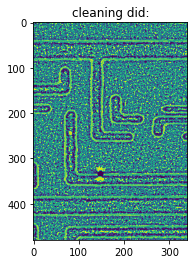

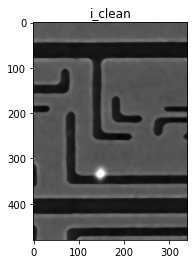

In [110]:
from noise_cleaning.NoiseCleaner import NoiseCleaner
noise_cleaner = NoiseCleaner()
r_clean = reference
i_clean = inspected
# want edge preservation, so no gaussian blur
# r_clean = noise_cleaner.blur(reference)
# i_clean = noise_cleaner.blur(inspected)

# r_clean = noise_cleaner.equalize_histogram(r_clean)
r_clean = noise_cleaner.clean_salt_and_pepper(r_clean, radius=11)
# r_clean = noise_cleaner.bilateral_filter(r_clean, sigma_color=0.1, sigma_spatial=1)

# i_clean = noise_cleaner.equalize_histogram(i_clean)
i_clean = noise_cleaner.clean_salt_and_pepper(i_clean, radius=11)
# i_clean = noise_cleaner.bilateral_filter(i_clean, sigma_color=0.1, sigma_spatial=10)
# i_clean -= i_clean.min()
# i_clean /= i_clean.max()
# i_clean *= 255
# i_clean = i_clean.astype('uint8')

plt.figure()
plt.title("cleaning did:")
plt.imshow((i_clean.astype("int") - inspected.astype("int")).astype("uint8"))
plt.show()



# plt.figure()
# plt.title('r_clean')
# plt.imshow(r_clean, cmap='gray')
plt.figure()
plt.title('i_clean')
plt.imshow(i_clean, cmap='gray')

Fight the displacement with simple feature based alignment.
(since the images are pretty close and not rotated, area based registration could be better, but less robust)



Enter config
Leave config
forcing tform [[  1.           0.         -23.79666277]
 [  0.           1.           3.67256833]
 [  0.           0.           1.        ]] to translation only
tform: [[ 1.00000000e+00 -7.32312709e-15  2.37966628e+01]
 [-8.86507347e-17  1.00000000e+00 -3.67256833e+00]
 [ 1.79778246e-17 -8.82057310e-17  1.00000000e+00]]
moving should be strided 23.79666276628447 down and -3.6725683348156 right 


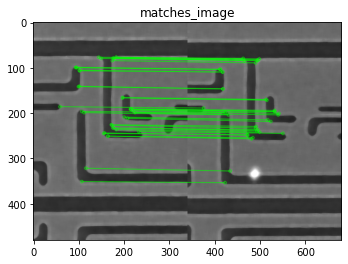

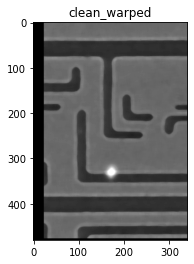

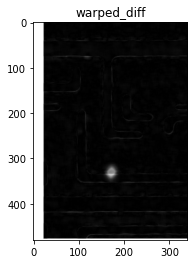

In [111]:
from alignment.Aligner import Aligner
aligner = Aligner()
matches_image, tform = aligner.align_using_feature_matching(static=r_clean, moving=i_clean)
clean_warped, warped_mask = aligner.align_using_tform(r_clean, i_clean, tform)
print(f"tform: {tform}")
print(f"moving should be strided {tform[0, 2]} down and {tform[1, 2]} right ")

plt.figure()
plt.title('matches_image')
plt.imshow(matches_image, cmap='gray')
plt.figure()
plt.title('clean_warped')
plt.imshow(clean_warped, cmap='gray')

warped_diff = np.ones(inspected.shape) * 255
warped_diff[warped_mask] = np.array(clean_warped, dtype=np.int)[warped_mask]
warped_diff[warped_mask] -= np.array(r_clean, dtype=np.int)[warped_mask]
warped_diff = np.array(np.abs(warped_diff), dtype=np.uint8)

plt.figure()
plt.title('warped_diff')
plt.imshow(warped_diff, cmap='gray')
plt.show()

Looks like the registration is not perfect. Let's try cross correlation instead

Enter config
Leave config
moving_should_be_strided_by: [-2 25]


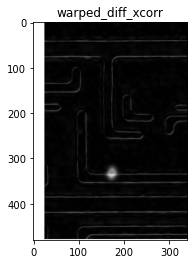

In [112]:
from alignment.Aligner import Aligner
aligner = Aligner()
moving_should_be_strided_by = aligner.align_using_normxcorr(r_clean, i_clean)
print(f"moving_should_be_strided_by: {moving_should_be_strided_by}")
clean_warped_xcorr, warped_mask_xcorr = aligner.align_using_shift(r_clean, i_clean, moving_should_be_strided_by)
warped_diff_xcorr = np.ones(inspected.shape) * 255
warped_diff_xcorr[warped_mask_xcorr] = np.array(clean_warped_xcorr, dtype=np.int)[warped_mask_xcorr]
warped_diff_xcorr[warped_mask_xcorr] -= np.array(r_clean, dtype=np.int)[warped_mask_xcorr]
warped_diff_xcorr = np.array(np.abs(warped_diff_xcorr), dtype=np.uint8)

plt.figure()
plt.title('warped_diff_xcorr')
plt.imshow(warped_diff_xcorr.astype('uint8'), cmap='gray')
plt.show()

By looking at the tform matrix directly, we can see the tform is almost only a translation (good).
We also see that the noise in the (cleaned) images will make a direct subtraction ineffective.

Let's segment the reference image, then apply the segmentaion to the warped image,
and check the probability of each pixel based on its neighbourhood
which is also inside its segment.

Try KMeans


Enter config
Leave config
Enter config
Leave config


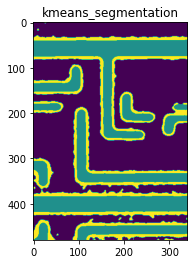

In [113]:
from segmentation.Segmenter import Segmenter
segmenter = Segmenter()
kmeans_segmentation = segmenter.segment_image_by_kmeans(reference)
# kmeans_segmentation = noise_cleaner.bilateral_filter(kmeans_segmentation, sigma_spatial=15)
# uniq = np.unique(kmeans_segmentation)
# for i, val in enumerate(uniq):
#     kmeans_segmentation[kmeans_segmentation == val] = i
kmeans_segmentation = noise_cleaner.majority(kmeans_segmentation.astype('uint8'), radius=3)

plt.figure()
plt.title("kmeans_segmentation")
plt.imshow(kmeans_segmentation)
plt.show()

Not good enough, still noisy. Could try denoising, but instead,
Let's try to look at the histogram, to see if thresholding is any good, and which to choose

In [89]:
# r_intersection = r_clean
# r_intersection[~warped_mask] = 0
# warped_intersection = clean_warped
# clean_warped[~warped_mask] = 0
#
# plt.figure()
# plt.title('intersection_hist')
# plt.hist(r_clean[warped_mask].ravel(), bins=128, color='red', label='reference histogram at intersection')
# plt.hist(clean_warped[warped_mask].ravel(), bins=128, color='blue', label='warped histogram at intersection')
# plt.legend()
#
# intersection_diff = np.array(r_intersection, dtype=np.int) - np.array(warped_intersection, dtype=np.int)
# plt.figure()
# plt.title('intersection_diff')
# plt.hist(intersection_diff.ravel(), bins=128, color='green', label='intersection_diff_hist')
# plt.show()
#

We see 3 major clusters of pixels, as can be expected by just looking at the picture:
1. Background.
2. Dark segments.
3. Dark segments' very light borders.

It also seems the distribution within each cluster is Gaussian.

In [90]:
# threshold_segmentation, hist, smooth_hist, low_thres, high_thres = segmenter.segment_image_by_threshold(reference)
# # threshold_segmentation = noise_cleaner.majority(threshold_segmentation, radius=2)
#
# if hist is not None:
#     plt.figure()
#     plt.title(f"chosen thresholds: {low_thres}, {high_thres}")
#     plt.plot(hist, color="blue")
#     plt.plot(smooth_hist, color="red")
#     plt.show()
#
# plt.figure()
# plt.title("threshold_segmentation")
# plt.imshow(threshold_segmentation)
#

Moving on to infering if a pixel is within its segment's distribution

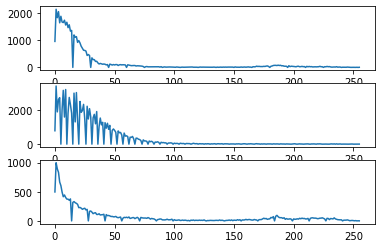

In [8]:
# fig, ax = plt.subplots(nrows=config.segmentation.num_classes, ncols=1)
# for c, row in enumerate(ax):
#     warped_c = np.logical_and(r_clean, threshold_segmentation==c)
#     hist_c, bins = np.histogram(warped_diff[warped_c], bins=256)
#     row.plot(hist_c)
# plt.show()

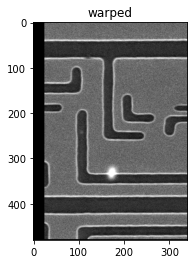

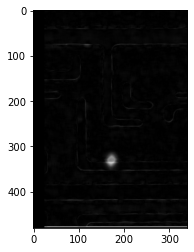

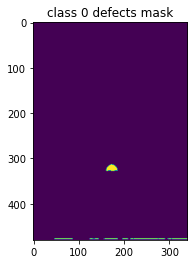

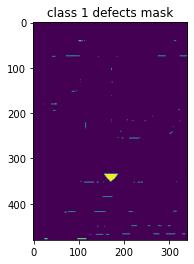

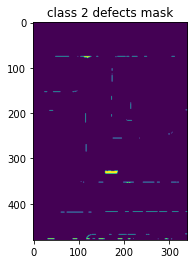

In [104]:
segmentation_map = kmeans_segmentation

# warped = aligner.align_using_tform(static=reference, moving=inspected, tform=tform)
warped, warped_region_mask = aligner.align_using_shift(static=reference, moving=inspected, shift_xy=moving_should_be_strided_by)
plt.figure()
plt.title("warped")
plt.imshow(warped, cmap='gray')
plt.show()

original_warped_diff = warped_diff.copy()
original_warped_diff[~warped_region_mask] = 0
plt.figure()
plt.imshow(original_warped_diff, cmap='gray')
plt.show()

for c in range(config.segmentation.num_classes):
    temp_diff = original_warped_diff.copy()
    temp_diff[~(segmentation_map==c)] = 0

    class_c_thres = 30
    plt.figure()
    plt.title(f'class {c} defects mask')
    defects_class_c = np.zeros_like(temp_diff)
    defects_class_c[class_c_thres < temp_diff] = 255
    defects_class_c[temp_diff <= class_c_thres] = 0
    plt.imshow(defects_class_c)


plt.show()

